In [1]:
import nbimporter
from extract_digits import (load_image, threshold_img, find_center_3by3_square, find_all_squares,
                            extract_digit_images, plot_all_squares, plot_center_3by3)
from solve_sodoku import SodokuField
from recognize_digits import DigitPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt

Importing Jupyter notebook from extract_digits.ipynb
Importing Jupyter notebook from solve_sodoku.ipynb
Importing Jupyter notebook from recognize_digits.ipynb


Using TensorFlow backend.


In [2]:
def try_except(try_fn, except_fn=None):
    try:
        return True, try_fn()
    except:
        return False, (except_fn() if except_fn else None)


def copy_image(src, dest, dest_topleft):
    dest_channels = dest.shape[2]
    
    if len(src.shape) == 2:
        src_rows, src_cols = src.shape
        new_src = np.zeros((src_rows, src_cols, dest_channels))
        for i in range(dest_channels):
            new_src[:, :, i] = src
        src = new_src
    else:
        src_rows, src_cols, src_channels = src.shape
        assert src_channels == dest_channels

    dest_top, dest_left = dest_topleft
    dest[dest_top:dest_top+src_rows, dest_left:dest_left+src_cols, :] = src
    return dest

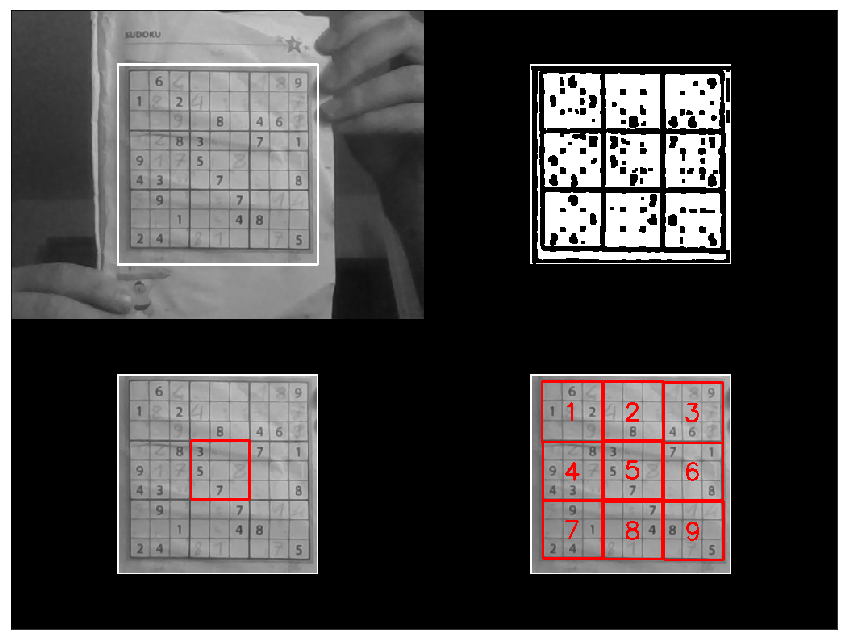

In [8]:
cap = cv2.VideoCapture(0)

try:
    success = False
    while True:
        ret, frame = cap.read()

        res = load_image(frame)
        orig = res['img'].copy()
        rows, cols = orig.shape
        
        half_target_size = int(min(rows, cols) * 0.325)
        target_top = int(rows / 2 - half_target_size)
        target_bot = int(rows / 2 + half_target_size)
        target_left = int(cols / 2 - half_target_size)
        target_right = int(cols / 2 + half_target_size)
        
        cv2.rectangle(orig, (target_left, target_top), (target_right, target_bot), (255, 0, 0), 2)
        res['img'] = orig[target_top:target_bot, target_left:target_right]
        
        final = np.zeros((rows * 2, cols * 2, 3))
        copy_image(orig, final, (0, 0))
        
        res = threshold_img(res)
        copy_image(res['bin'], final, (target_top, target_left + cols))
        
        ok, res = try_except(lambda: find_center_3by3_square(res))
        
        if ok:
            copy_image(plot_center_3by3(res, None), final, (target_top + rows, target_left))
            ok, res = try_except(lambda: find_all_squares(res))
        
        if ok:
            copy_image(plot_all_squares(res, None), final, (target_top + rows, target_left + cols))
            ok, res = try_except(lambda: extract_digit_images(res))
        
        # Display the resulting frame (horizontal mirror to make interaction easier)
        cv2.imshow('frame', final.astype(np.uint8)[:, ::-1, :])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
        # check if squares are reasonable
        if ok and 'squares' in res:
            success = True  # let's be optimists
            
            # exactly 9 squares
            if len(res['squares']) != 9:
                success = False
            
            # longest side must be less than 1/3 of picture
            max_side = max(max((bx - ax), (by - ay)) for ax, ay, bx, by in res['squares'])
            if max_side > 2 * half_target_size / 3:
                success = False
            
            # shortest side must be more than 1/5 of the picture
            min_side = min(min((bx - ax), (by - ay)) for ax, ay, bx, by in res['squares'])
            if min_side < 2 * half_target_size / 4:
                success = False
            
            # smallest area / largest area > 0.92
            areas = [(bx - ax) * (by - ay) for ax, ay, bx, by in res['squares']]
            if min(areas) / max(areas) < 0.9:
                success = False
            
            if success:
                break
    
    plt.figure(figsize=(12, 9))
    plt.imshow(final.astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    
finally:
    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

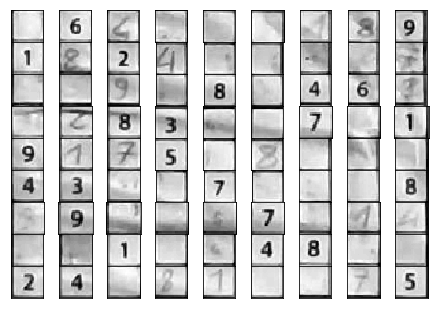

In [9]:
res = extract_digit_images(res)

for i, digit in enumerate(res['digits']):
    plt.subplot(9, 9, i + 1)
    plt.imshow(digit['img'], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
plt.show()

In [45]:
preds = DigitPredictor().predict_digits([digit['img'] for digit in res['digits']], return_proba=True)
labeled_digits = preds.argmax(axis=1)
confidence = preds.max(axis=1)

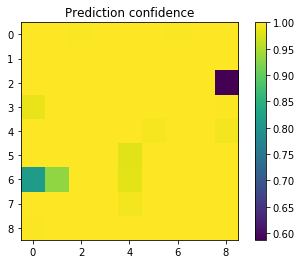

In [46]:
plt.imshow(confidence.reshape((9, 9)))
plt.colorbar()
plt.title('Prediction confidence')
plt.show()

I am not sure of the content of the cell in row 3 and column 9
I think it is a 3, but I am only 58.7% confident.


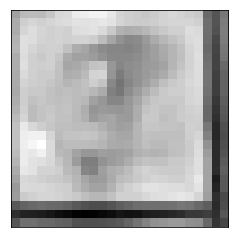

What is the correct label?  2


I am not sure of the content of the cell in row 7 and column 1
I think it is a 8, but I am only 81.5% confident.


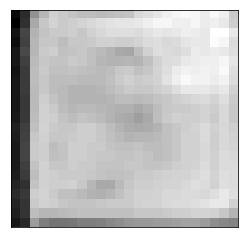

What is the correct label?  8


In [54]:
correct_labels = []
for i, (conf, digit_data, label) in enumerate(zip(confidence, res['digits'], labeled_digits)):
    if conf > 0.9:
        correct_labels.append(label)
    else:
        row, col = i // 9 + 1, i % 9 + 1
        print('I am not sure of the content of the cell in row %d and column %d' % (row, col))
        print('I think it is %s, but I am only %.1f%% confident.' % (
            (('a %d' % label) if label else 'blank'), 100 * conf
        ))
        plt.imshow(digit_data['img'], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        label = input('What is the correct label? ')
        correct_labels.append(int(label) if label.isdigit() else None)

In [57]:
sodoku = SodokuField(correct_labels)
sodoku.pretty_print()

+---------+---------+---------+
|    6  4 |         | 1  8  9 |
| 1  8  2 | 4       |       7 |
|       9 |    8    | 4  6  2 |
+---------+---------+---------+
|    2  8 | 3       | 7     1 |
| 9  1  7 | 5     8 |         |
| 4  3    |    7    |       8 |
+---------+---------+---------+
| 8  9    |       7 |    1  4 |
|       1 |       4 | 8       |
| 2  4    | 8  1    |    7  5 |
+---------+---------+---------+



In [58]:
solved, _ = sodoku.brute_force()
sodoku.pretty_print()
solved

+---------+---------+---------+
| 5  6  4 | 7  3  2 | 1  8  9 |
| 1  8  2 | 4  9  6 | 5  3  7 |
| 3  7  9 | 1  8  5 | 4  6  2 |
+---------+---------+---------+
| 6  2  8 | 3  4  9 | 7  5  1 |
| 9  1  7 | 5  2  8 | 3  4  6 |
| 4  3  5 | 6  7  1 | 2  9  8 |
+---------+---------+---------+
| 8  9  3 | 2  5  7 | 6  1  4 |
| 7  5  1 | 9  6  4 | 8  2  3 |
| 2  4  6 | 8  1  3 | 9  7  5 |
+---------+---------+---------+



True